# Summary

Generating all the analysis I need for my final report.

### Descriptives

1. Show velocity converging to 0 for unhealthy repos vs. healthy repos
1. Provide general overview of the data
1. Speak to data processing
1. Speak to data cleaning
1. Speak to feature engineering

### Predictives

1. Correlation matrix with features (multicollinearity)
1. Show forecasting algorithm (linear regression)
1. Run and report several forecasts
1. Check for autocorrelation, plot residuals

# Dependencies

In [1]:
library(dplyr)
library(ggplot2)
library(readr)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Load Data

In [2]:
rdir <- "~/code/rcompat/"
list.files(rdir)

[1] "authors_prototype.csv"    "commits_prototype.csv"   
[3] "df_features_20190424.csv" "df_target_20190424.csv"  
[5] "meta_prototype.csv"

In [3]:
authors_prototype <- read_csv(paste0(rdir, 'authors_prototype.csv'))
dim(authors_prototype)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  commit_hash = col_character(),
  name = col_character(),
  email = col_character(),
  authored = col_datetime(format = "")
)


[1] 928779      5

In [4]:
commits_prototype <- read_csv(paste0(rdir, 'commits_prototype.csv'))
dim(commits_prototype)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  file_id = col_integer(),
  commit_hash = col_character(),
  modified_file = col_character(),
  lines_added = col_integer(),
  lines_subtracted = col_integer()
)


[1] 2327964       6

In [5]:
meta_prototype <- read_csv(paste0(rdir, 'meta_prototype.csv'))
dim(meta_prototype)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  commit_hash = col_character(),
  owner_name = col_character(),
  project_name = col_character()
)


[1] 928779      4

In [6]:
df_target <- read_csv(paste0(rdir, 'df_target_20190424.csv'))
dim(df_target)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  ts = col_integer(),
  owner_name = col_character(),
  project_name = col_character(),
  lines_added = col_integer(),
  lines_deleted = col_integer(),
  velocity = col_integer()
)


[1] 14650     7

In [7]:
df_features <- read_csv(paste0(rdir, 'df_features_20190424.csv'))
dim(df_features)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  index = col_integer(),
  ts = col_integer(),
  owner_name = col_character(),
  project_name = col_character(),
  num_authors = col_integer(),
  org_name = col_integer(),
  mentor_count = col_double()
)


[1] 14650     8

# Data Preprocessing

We need to create a working table for the prototype data.

In [8]:
# one to one join

df <- meta_prototype %>% select(-X1) %>%
    inner_join(authors_prototype %>% select(-X1), by=c('commit_hash' = 'commit_hash'))


dim(df)

[1] 928779      6

In [9]:
# one to many join where meta_info without commits info is removed with right_join

df <- df %>%  
        right_join(commits_prototype %>% select(-X1), 
                   by=c('commit_hash' = 'commit_hash'))

dim(df)[1] == dim(commits_prototype)[1] # check dimensions

[1] TRUE

# Descriptives

Generate descriptive stats and figures for report and presentation.

## Provide general overview of the data

In [10]:
projects <- df_features %>% select(owner_name, project_name) %>% unique()

In [11]:
# 2019-04-24 14:11:45,170 INFO Completed 2869 successes, 58 failures

projects %>% count()

n
2869


Saving 7 x 7 in image


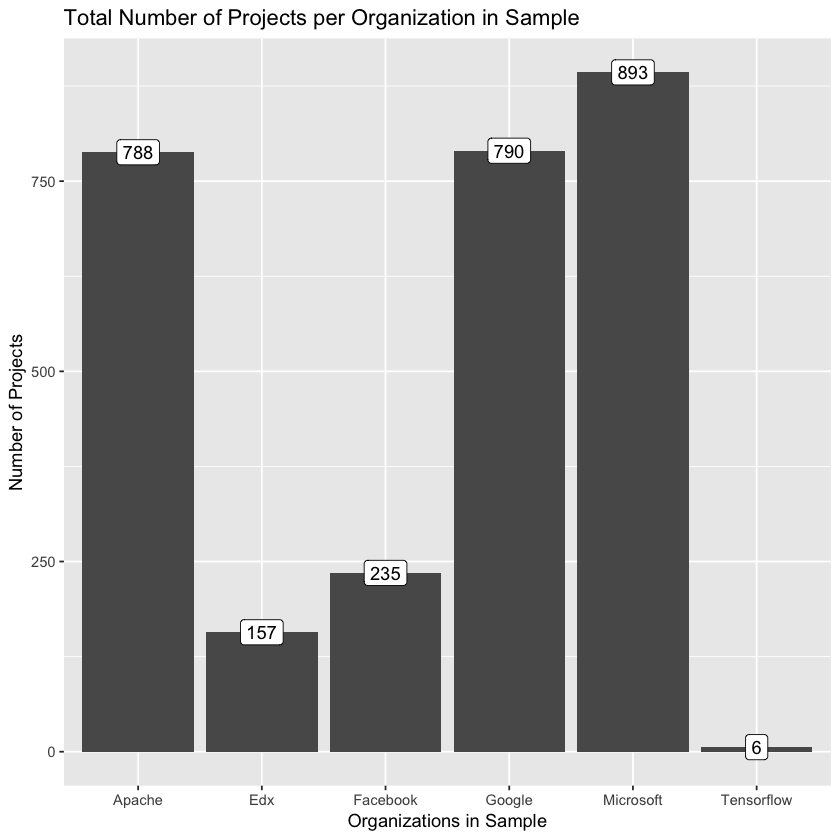

In [12]:
# Projects by organization

orgs <- projects %>% group_by(owner_name) %>% count() %>% 
            ungroup() %>%
            mutate(owner_name = str_to_title(owner_name))
f1 <- ggplot(orgs, aes(owner_name, n)) + geom_col() + 
        geom_label(aes(label=n)) +
        labs(title='Total Number of Projects per Organization in Sample',
             y='Number of Projects',
             x='Organizations in Sample')
ggsave('imgs/f1.png')
f1

### Show velocity by organization $\downarrow$

In [17]:
minimal_projs <- df_target %>% filter(ts == 2018) %>% mutate(minimal =  velocity > -100 & velocity <= 100)
dim(minimal_projs)

[1] 1515    8

In [18]:
all_projs <- df_target %>% select(owner_name, project_name) %>% unique()
dim(all_projs)

[1] 2869    2

In [19]:
full_list <- minimal_projs %>% 
                select(-X1) %>% 
                full_join(all_projs, 
                          by=c("owner_name" = "owner_name", "project_name" = "project_name"))

dim(full_list)[1] == dim(all_projs)[1]

[1] TRUE

In [20]:
summary(full_list$minimal)

   Mode   FALSE    TRUE    NA's 
logical    1095     420    1354 

In [22]:
# Get all projects in 2018 irrespective of commits present

full_imp_list <- full_list %>%
                mutate(
                    ts = ifelse(is.na(ts), 2018, ts),
                    minimal = ifelse(is.na(minimal), TRUE, minimal),
                    lines_added = ifelse(is.na(lines_added), 0, lines_added),
                    lines_deleted = ifelse(is.na(lines_deleted), 0, lines_deleted),
                    velocity = ifelse(is.na(velocity), 0, velocity)
                )
summary(full_imp_list$minimal)

   Mode   FALSE    TRUE 
logical    1095    1774 

In [23]:
orgmove <- full_imp_list %>% 
            group_by(owner_name) %>% 
            summarize(n = n(), dead = sum(minimal)) %>%
            ungroup() %>%
            mutate(fdead = cut(dead/n * 100, breaks=4),
                  owner_name = str_to_title(owner_name))

head(orgmove)

owner_name,n,dead,fdead
Apache,788,423,"(43.7,57.2]"
Edx,157,109,"(57.2,70.8]"
Facebook,235,146,"(57.2,70.8]"
Google,790,559,"(57.2,70.8]"
Microsoft,893,536,"(57.2,70.8]"
Tensorflow,6,1,"(16.6,30.2]"


Saving 7 x 7 in image


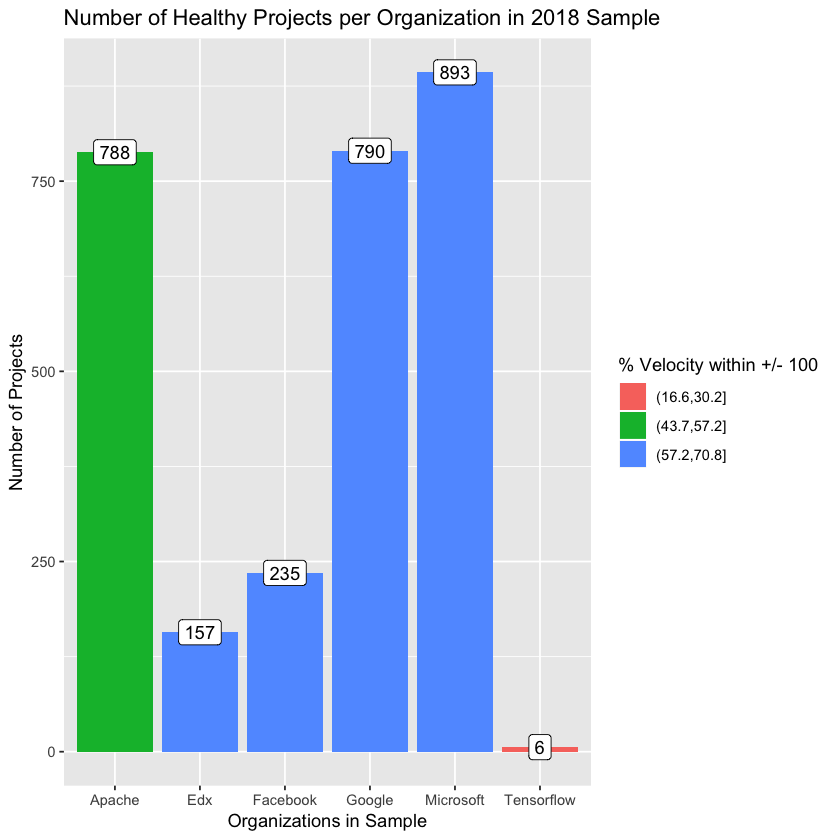

In [26]:
f2 <- ggplot(orgmove, aes(owner_name, n, fill=fdead)) + geom_col() + 
        geom_label(aes(label=n), fill='white') +
        labs(title='Number of Healthy Projects per Organization in 2018 Sample',
             y='Number of Projects',
             x='Organizations in Sample',
             fill='% Velocity within +/- 100')
ggsave('imgs/f2.png')
f2

Figure 2 seems like a nice idea but too much information for the audience initially.
Let's show something similar at the end once we've established some metrics. This
should actually go at the end.

## Show velocity converging to 0 for unhealthy repos vs. healthy repos

I established baseline behavior by reviewing well known and Apache open 
source projects to see if I could find any patterns.